In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [15]:
# Save references to each table
Station  = Base.classes.station
Measurement  = Base.classes.measurement

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

station_inspector = inspect(engine)
columns = station_inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])
    
measurement_inspector = inspect(engine)
columns = measurement_inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [74]:
# Find the most recent date in the data set.
most_recent_record = session.query(Measurement).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_record.date
print(most_recent_date)

2017-08-23


Date one year ago: 2016-08-23 00:00:00


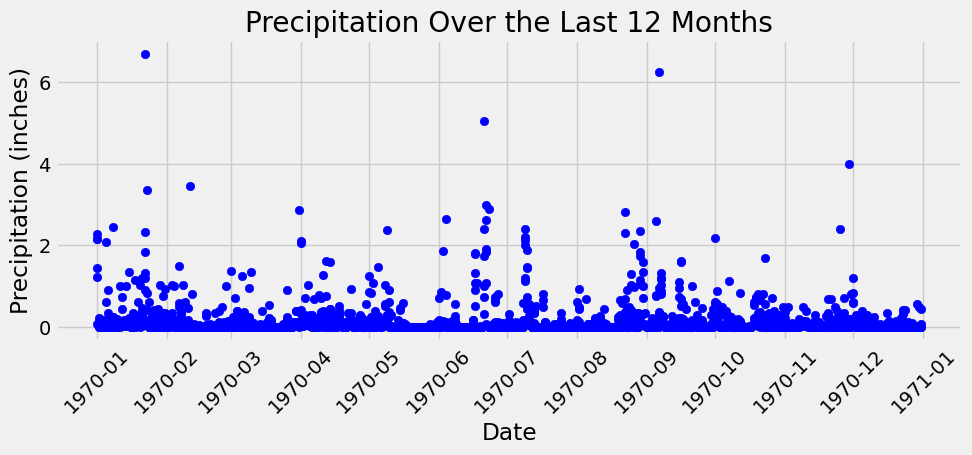

In [104]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_datetime = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date_datetime - dt.timedelta(days=365)
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')



plt.figure(figsize=(10, 5))
plt.scatter(precipitation_df['date'], precipitation_df['precipitation'], color='b', marker='o')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()  
# Adjust layout to prevent clipping of tick-labels
import matplotlib.dates as mdates
plt.tight_layout()  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

In [106]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = pd.DataFrame(precipitation_df['precipitation'].describe())
summary_statistics

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [109]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(func.count(Station.station.distinct())).scalar()
print(f"Total number of stations: {stations_count}")

Total number of stations: 9


In [117]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).all()

# List the stations and their counts in descending order.
from sqlalchemy import desc
most_active_stations_sorted = sorted(most_active_stations, key=lambda x: x[1], reverse=True)
most_active_stations_sorted

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [129]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations_sorted[0][0]
min_max_avg_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

min_max_avg_temp

[(54.0, 85.0, 71.66378066378067)]

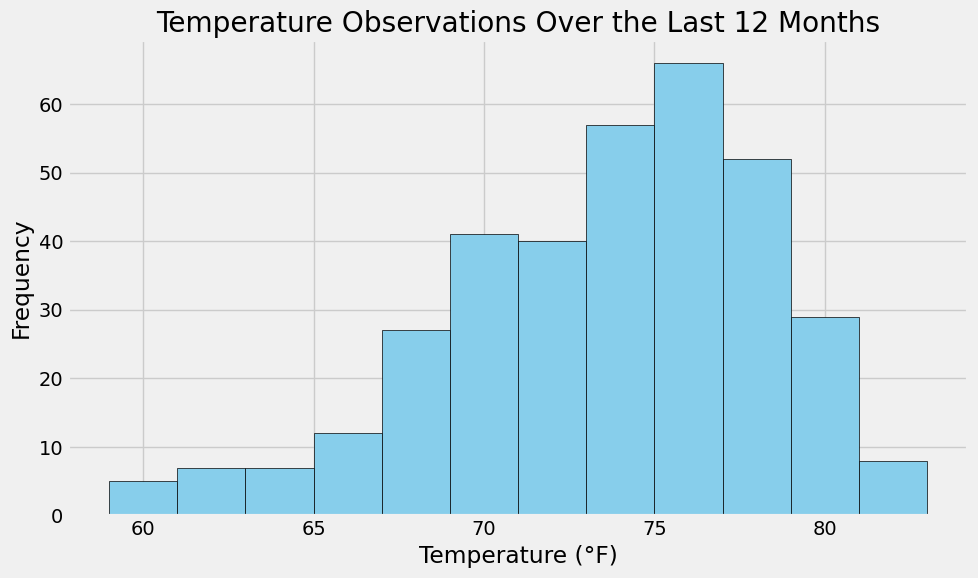

In [131]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == most_active_station_id).\
                    filter(Measurement.date >= one_year_ago).\
                    order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations Over the Last 12 Months')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [132]:
# Close Session
session.close()